In [16]:
import os
import tqdm
import helpers

import entries_extractor as ee

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

- subtoken vocab size:  3592
- node vocab size:  76
- target vocab size:  3583
- File: data/code2seq/agda/agda.test.raw.txt
- Average total contexts: 857.1310344827587
- Average final (after sampling) contexts: 193.30711665443874
- Total examples: 6815
- Max number of contexts per word: 1000
- File: data/code2seq/agda/agda.val.raw.txt
- Average total contexts: 862.6340011614402
- Average final (after sampling) contexts: 193.50566202090593
- Total examples: 6888
- Max number of contexts per word: 1000
- File: data/code2seq/agda/agda.train.raw.txt
- Average total contexts: 859.3084578032974
- Average final (after sampling) contexts: 859.3084578032974
- Total examples: 54163
- Max number of contexts per word: 1000

- Count 3583 label, top-5: [('_', 52112), ('is', 15137), ('theory', 9862), ('algebra', 7745), ('group', 5018)]
- Count 4410 token, top-5: [('1', 12445877), ('0', 10537235), ('_', 10093967), ('2', 8731488), ('', 7604772)] 
- Count 76 node, top-5: [('2', 74719968), ('8', 67709184), ('13', 54458018), ('', 46542724), ('11', 38571155)]

In [17]:
def number_of_unique_pairs(total: int) -> int:
    """
    `total-1` paths from the first, `total-2` from the second...
    """
    return total * (total - 1) / 2


def generate_report(library_path: str):
    import pandas as pd

    leaves = 0
    entries = 0
    paths = 0
    name_paths = 0
    max_leaves = 0
    max_entry = None
    functions = 0
    function_paths = 0
    entries_dir = os.path.join(library_path, "entries")
    log = open(os.path.join(library_path, "entries_stats.tsv"), "w", encoding="utf-8")
    log.write("file_name\tentry_type\tnum_nodes\tnum_edges\tnum_leaves\tnum_names")

    labels_dict = {}
    with open(os.path.join(library_path, "nodes.tsv"), "r", encoding="utf-8") as f:
        f.readline()
        for line in f:
            parts = line.split("\t")
            labels_dict[str(parts[0])] = eval(parts[1])

    print("Calculating total number of paths...")
    for file in tqdm.tqdm(os.listdir(entries_dir)):
        if not file.endswith(".dag"):
            continue
        entries += 1
        entry_nodes = 0
        entry_edges = 0
        entry_leaves = 0
        entry_names = 0
        with open(os.path.join(entries_dir, file), "r", encoding="utf-8") as f:
            f.readline()  # id, type, description, children ids
            name = None
            for line in f:
                entry_nodes += 1
                parts = line.split("\t")
                node_type = parts[1]
                node_children = eval(parts[3])

                if not node_children:
                    leaves += 1
                    entry_leaves += 1
                else:
                    entry_edges += len(node_children)
                if node_type == ":name":
                    if not name:
                        name = str(parts[2]).replace('"', "")
                    entry_names += 1

        entry_type = labels_dict[name]["label"].replace(":", "")

        if entry_type == "function":
            functions += 1
            function_paths += number_of_unique_pairs(entry_leaves)
            # if function_paths_carry >= BILLION:
            #     function_paths_billions += function_paths_carry // BILLION
            #     function_paths_carry = function_paths_carry % BILLION

        log.write(
            f"\n{file}\t{entry_type}\t{entry_nodes}\t{entry_edges}\t{entry_leaves}\t{entry_names}"
        )
        paths += number_of_unique_pairs(entry_leaves)
        name_paths += number_of_unique_pairs(entry_names)
        # if paths_carry >= BILLION:
        #     paths_billions += paths_carry // BILLION
        #     paths_carry = paths_carry % BILLION
        # if name_paths_carry >= BILLION:
        #     name_paths_billions += name_paths_carry // BILLION
        #     name_paths_carry = name_paths_carry % BILLION
        if entry_leaves > max_leaves:
            max_leaves = entry_leaves
            max_entry = file

    log.close()

    print("Making numbers printable...")
    paths_power = 0
    name_paths_power = 0
    function_paths_power = 0
    while paths > 10:
        paths_power += 1
        paths = paths // 10
    while name_paths > 10:
        name_paths_power += 1
        name_paths = name_paths // 10
    while function_paths > 10:
        function_paths_power += 1
        function_paths = function_paths // 10

    print(
        "-------REPORT-------",
        "\nTotal number of leaves: ",
        leaves,
        f"\n\tOn average {leaves / entries} leaves for each entry.",
        "\n\tMax leaves: ",
        max_leaves,
        "\n\tEntry with most leaves: ",
        max_entry,
        f"\nTotal paths (billions): {paths} * 10^{paths_power}",
        f"\nTotal paths between :name entries (billions): {name_paths} * 10^{name_paths_power}",
        f"\nTotal paths in :function entries (billions): {function_paths} * 10^{function_paths_power}",
        "\n\tTotal :function entries: ",
        functions,
    )

In [18]:
entries_stats = pd.read_csv("./data/raw/stdlib/entries_stats.tsv", sep="\t")
entries_stats

,file_name,entry_type,num_nodes,num_edges,num_leaves,num_names
0,Agda.Builtin.Bool_0000.dag,constructor,16,15,6,3
1,Agda.Builtin.Bool_0001.dag,data,10,9,4,3
2,Agda.Builtin.Bool_0002.dag,data,10,9,4,3
3,Agda.Builtin.Char.Properties_0000.dag,axiom,91,90,43,9
4,Agda.Builtin.Char_0000.dag,axiom,11,10,4,1
...,...,...,...,...,...,...
16478,Text.Printf_0003.dag,function,685,684,325,73
16479,Text.Printf_0004.dag,function,1154,1153,680,153
16480,Text.Printf_0005.dag,function,382,381,218,57
16481,Text.Printf_0006.dag,function,303,302,171,45


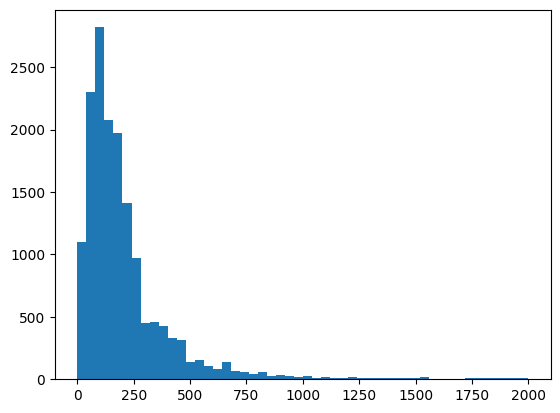

In [19]:
_ = plt.hist(
    entries_stats["num_leaves"],
    bins=50,
    range=(0, 2000),
    # log=True,
)

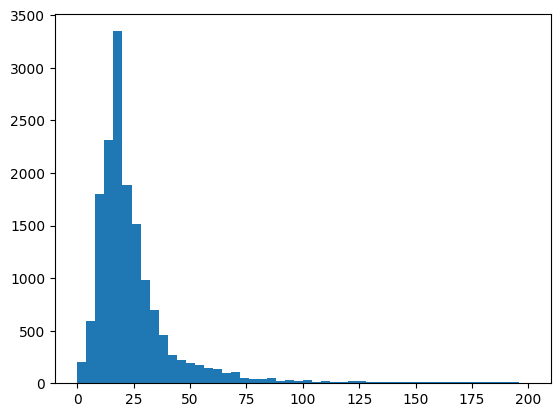

In [20]:
_ = plt.hist(
    entries_stats["num_names"],
    bins=50,
    range=(0, 200),
    # log=True,
)

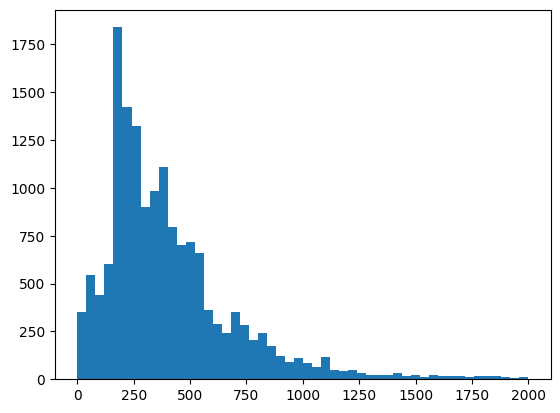

In [21]:
_ = plt.hist(
    entries_stats["num_nodes"],
    bins=50,
    range=(0, 2000),
    # log=True,
)

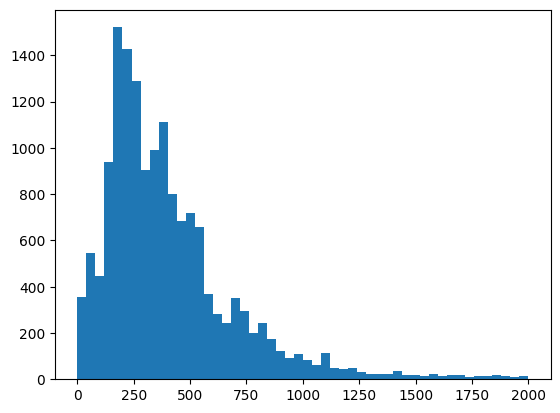

In [22]:
_ = plt.hist(
    entries_stats["num_edges"],
    bins=50,
    range=(0, 2000),
    # log=True,
)

In [23]:
function_entries = entries_stats[entries_stats["entry_type"] == "function"].drop(
    "entry_type", axis=1
)
function_entries

,file_name,num_nodes,num_edges,num_leaves,num_names
18,Agda.Builtin.Coinduction_0000.dag,48,47,11,4
21,Agda.Builtin.Cubical.Glue_0000.dag,462,461,150,10
22,Agda.Builtin.Cubical.Glue_0001.dag,276,275,64,6
23,Agda.Builtin.Cubical.Glue_0002.dag,386,385,148,26
24,Agda.Builtin.Cubical.Glue_0003.dag,294,293,96,16
...,...,...,...,...,...
16477,Text.Printf_0002.dag,399,398,197,51
16478,Text.Printf_0003.dag,685,684,325,73
16479,Text.Printf_0004.dag,1154,1153,680,153
16480,Text.Printf_0005.dag,382,381,218,57


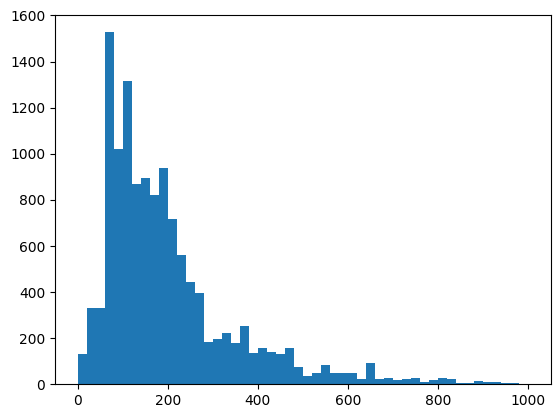

In [24]:
_ = plt.hist(
    function_entries["num_leaves"],
    bins=50,
    range=(0, 1000),
)

In [25]:
def count_tokens_in_file(file_path: str):
    entry_counts = {
        "entry": [],
        "label parts": [],
        "non-empty contexts": [],
        "empty contexts": [],
        "empty label subtokens": [],
        "empty context subtokens": [],
    }
    token_counts = {
        "entry": [],
        "left": [],
        "path": [],
        "right": [],
        "problems": [],
    }
    with open(file_path, "r", encoding="utf-8") as f:
        for line_number, line in tqdm.tqdm(enumerate(f)):
            line_number += 1
            parts = line.strip("\n").split(" ")
            label_parts = parts[0].split("|")

            entry_counts["entry"].append(line_number)
            entry_counts["label parts"].append(len(label_parts))
            entry_counts["non-empty contexts"].append(len(parts) - 1)
            entry_counts["empty contexts"].append(0)
            entry_counts["empty label subtokens"].append(0)
            entry_counts["empty context subtokens"].append(0)

            for subtoken in label_parts:
                if subtoken == "":
                    entry_counts["empty label subtokens"][-1] += 1

            for i, context in enumerate(parts[1:]):
                if context == "":
                    entry_counts["non-empty contexts"][-1] = i
                    entry_counts["empty contexts"][-1] = len(parts) - 1 - i
                    break
                subparts = context.split(",")
                if len(subparts) < 3:
                    token_counts["entry"].append(line_number)
                    token_counts["left"].append(0)
                    token_counts["path"].append(0)
                    token_counts["right"].append(0)
                    token_counts["problems"].append(str(subparts))
                    continue
                left, path, right = subparts[:3]
                # If there's an error in the data - an aditional comma - there could be more parts
                problems = subparts[3:]

                left_parts = left.split("|")
                path_nodes = path.split("|")
                right_parts = right.split("|")

                for part in left_parts:
                    if part == "":
                        entry_counts["empty context subtokens"][-1] += 1
                for part in right_parts:
                    if part == "":
                        entry_counts["empty context subtokens"][-1] += 1

                token_counts["entry"].append(line_number)
                token_counts["left"].append(len(left_parts))
                token_counts["path"].append(len(path_nodes))
                token_counts["right"].append(len(right_parts))
                token_counts["problems"].append(str(problems))
    return pd.DataFrame(entry_counts), pd.DataFrame(token_counts)

In [26]:
entry_counts, token_counts = count_tokens_in_file("./data/code2seq/agda/predict.c2s")
# entry_counts, token_counts = count_tokens_in_file("./data/code2seq/agda/agda.val.raw.txt")

67866it [01:15, 899.59it/s] 


In [27]:
entry_counts

,entry,label parts,non-empty contexts,empty contexts,empty label subtokens,empty context subtokens
0,1,9,118,882,0,0
1,2,4,6,994,0,0
2,3,6,6,994,0,0
3,4,6,6,994,0,0
4,5,6,6,994,0,0
...,...,...,...,...,...,...
67861,67862,7,200,800,0,0
67862,67863,5,126,874,0,0
67863,67864,6,200,800,0,0
67864,67865,5,200,800,0,0


In [28]:
entry_counts[entry_counts["empty context subtokens"] != 0]

,entry,label parts,non-empty contexts,empty contexts,empty label subtokens,empty context subtokens


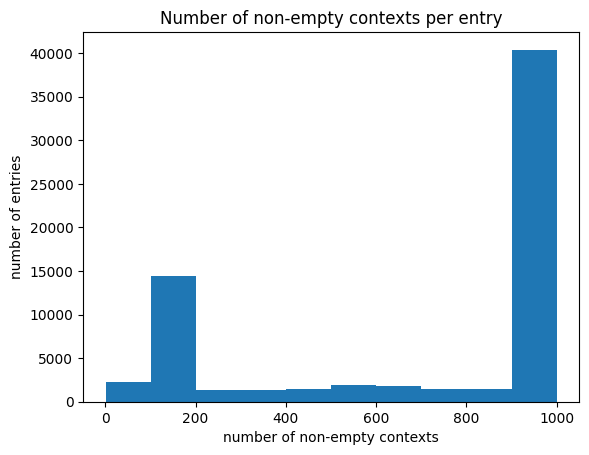

In [29]:
plt.hist(entry_counts["non-empty contexts"])
plt.title("Number of non-empty contexts per entry")
plt.xlabel("number of non-empty contexts")
plt.ylabel("number of entries")
print()

In [30]:
entry_counts[entry_counts["non-empty contexts"] == 0]["entry"]

Series([], Name: entry, dtype: int64)

3

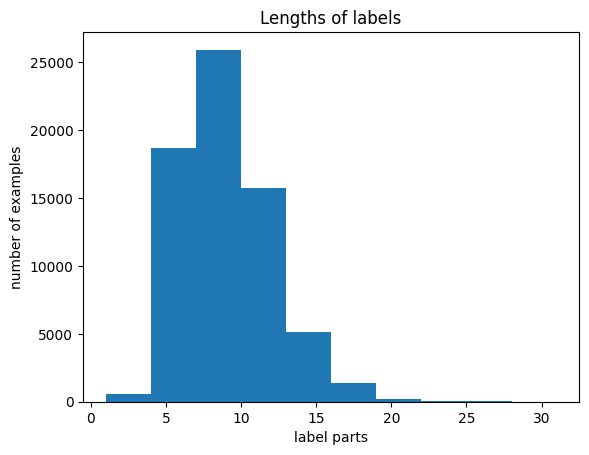

In [31]:
plt.hist(entry_counts["label parts"])
plt.title("Lengths of labels")
plt.xlabel("label parts")
plt.ylabel("number of examples")
entry_counts["label parts"][entry_counts["label parts"] == 1].count()

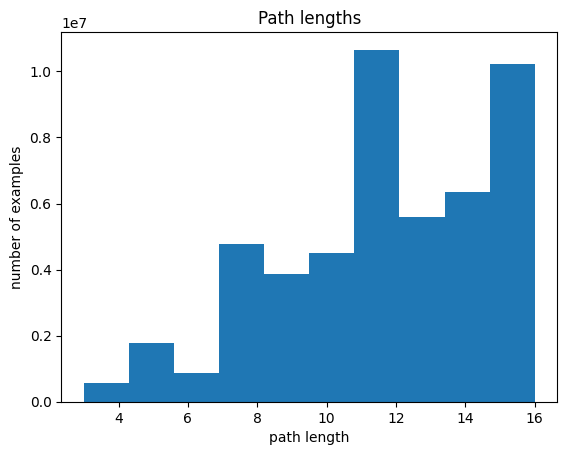

In [32]:
plt.hist(token_counts["path"])
plt.title("Path lengths")
plt.xlabel("path length")
plt.ylabel("number of examples")
print()

In [42]:
print("Quantiles:", entry_counts["label parts"].quantile([0.6, 0.7, 0.8, 0.9]), sep="\n")

Quantiles:
0.6     9.0
0.7    10.0
0.8    11.0
0.9    13.0
Name: label parts, dtype: float64


In [34]:
left = pd.DataFrame({"entry": token_counts["entry"], "parts": token_counts["left"]})
right = pd.DataFrame({"entry": token_counts["entry"], "parts": token_counts["right"]})

tokens = pd.concat([left, right], ignore_index=True)
combined_tokens = tokens["parts"]

In [35]:
print(
    "Min token length:",
    np.min(combined_tokens),
    "Max token length:",
    np.max(combined_tokens),
    "Mean token length:",
    np.mean(combined_tokens),
    "Median token length:",
    np.median(combined_tokens),
    "Token length quantiles 0.9, 0.99:",
    np.quantile(combined_tokens, [0.9, 0.99]),
    # np.percentile(combined_tokens, 0.9),
    "Percentage of empty tokens:",
    float(combined_tokens[combined_tokens <= 0].count()) / len(combined_tokens),
    "Number of empty tokens:",
    int(combined_tokens[combined_tokens <= 0].count()),
    "Percentage of tokens of length less than 2:",
    float(combined_tokens[combined_tokens <= 2].count()) / len(combined_tokens),
    "Percentage of tokens of length less than 3:",
    float(combined_tokens[combined_tokens <= 3].count()) / len(combined_tokens),
    "Percentage of tokens of length less than 4:",
    float(combined_tokens[combined_tokens <= 4].count()) / len(combined_tokens),
    sep="\n",
)

Min token length:
1
Max token length:
23
Mean token length:
1.3329561724651804
Median token length:
1.0
Token length quantiles 0.9, 0.99:
[2. 4.]
Percentage of empty tokens:
0.0
Number of empty tokens:
0
Percentage of tokens of length less than 2:
0.9147839267876011
Percentage of tokens of length less than 3:
0.97752832777214
Percentage of tokens of length less than 4:
0.9919271203315416


In [36]:
entries_with_empty_tokens = tokens[tokens["parts"] == 0].groupby(["entry"]).count()
entries_with_empty_tokens

,parts
entry,


In [37]:
token_counts[(token_counts["left"] == 0) | (token_counts["right"] == 0)][
    ["entry", "problems"]
]

,entry,problems


In [38]:
embeddings = helpers.read_embeddings("stdlib")

16483it [02:21, 116.58it/s]


In [41]:
for name, e in embeddings.items():
    print(name, e[0], sep="\n", end="\n\n")

Agda.Builtin.Bool.Bool 6
relation|binary|bundles|dec|total|order|dto|is|partial|order

Agda.Builtin.Bool.Bool.true 10
algebra|lattice|structures|is|boolean|algebra|_|\wedge|distrib{^l}|\vee

Agda.Builtin.Char.Char 6
algebra|bundles|ring|without|one|_|\approx|_

Agda.Builtin.Char.primIsLower 8
function|related|type|isomorphisms|\uplus|identity

Agda.Builtin.Char.primIsAlpha 12
data|nat|solver|+|*|solver|_|\ElsevierGlyph{225F}|n|_

Agda.Builtin.Char.primIsSpace 14
relation|binary|definitions|_|respects{^r}|_

Agda.Builtin.Char.primIsLatin1 18
data|nat|properties|_|is|semimedial|magma

Agda.Builtin.Char.primIsHexDigit 22
relation|binary|reasoning|base|double|begin|_

Agda.Builtin.Char.primCharToNat 28
data|nat|properties|_|is|commutative|semigroup|is|equivalence

Agda.Builtin.Char.primCharEquality 32
algebra|structures|is|semiring|_|*|assoc

Agda.Builtin.Coinduction.∞ 10
relation|binary|bundles|dec|setoid|setoid

Agda.Builtin.Coinduction.♯_ 16
algebra|structures|is|moufang|loop|_|is|quasi

In [48]:
import random
import filesystem as fs

In [77]:
file = "data/code2seq/agda/test.c2s"
line_offsets = fs.get_lines_offsets(file, False)
for offset in random.sample(line_offsets, 5):
    print(fs.get_line_by_offset(file, offset))

ordinals|injectivity|topped|ordinals|injectivity|_|ordinal{^T} fun|ext,1|8|2|10|2|0|23|24|26|11|2|81|,fun|ext ordinal{^T},1|8|27|24|23|0|2|10|2|81|,fun|ext 0,18|22|6|5|4|2|81|,_|\. _|\.,1|8|2|11|10|2|2|24|26|11|2|421|,0 0,21|4|2|10|2|0|23|24|2|2|10|2|81|,level lsuc,1|8|13|8|2|11|10|2|2|24|27|81|,ordinal{^T} fun|ext,1|8|2|11|26|24|25|3529|,fe 0,21|4|2|10|2|01|,METHOD_NAME 0,21|4|2|10|11|2|10|11|2|81|,_|\. 0,21|4|2|10|11|2|10|11|2|4|5|6|2218|,0 fe,1|11|26|24|2|2|10|11|2|81|,_|\. fe,29|35|25|24|26|111|,fe 0,18|13|8|27|24|2|2|10|2|81|,level fe,1|11|26|24|27|8|1318|,0 METHOD_NAME,1|0|2|10|111|,fe _|\.,1|8|2|11|10|2|2|24|23|01|,METHOD_NAME level,1|8|2|10|2|11|10|2|0|23|24|2|2|10|111|,\mathscr{U} \mathscr{U},1|11|2|81|,_|\. fe,29|35|25|24|23|0|2|10|2|81|,fun|ext 0,21|4|2|11|26|24|23|0|2|10|11|2|421|,0 \mathscr{U},1|11|10|2|2|24|23|0|2|10|2|421|,0 level,1|8|2|10|2|2|24|23|0|2|10|111|,fe 0,21|4|2|10|2|0|23|24|27|81|,ordinal{^T} lsuc,1|8|13|8|2|11|10|2|11|10|2|81|,fun|ext METHOD_NAME,1|0|23|24|2